# Improved Spoilage-Risk Prediction Model for Indian Produce

This notebook implements an enhanced machine learning model to predict spoilage risk for a wide variety of Indian produce based on environmental and storage factors.

In [15]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set(font_scale=1.2)

In [16]:
# Define a comprehensive list of Indian commodities by category
enhanced_commodities = {
    'Staple Grains': ['Bajra', 'Rice', 'Wheat', 'Maize', 'Jowar', 'Ragi', 'Barley', 'Sorghum', 'Millet', 'Amaranth'],
    'Vegetables': ['Tomato', 'Potato', 'Onion', 'Spinach', 'Cauliflower', 'Cabbage', 'Brinjal', 'Bitter Gourd', 'Lady Finger', 'Bottle Gourd', 'Ridge Gourd', 'Pumpkin'],
    'Fruits': ['Mango', 'Banana', 'Papaya', 'Guava', 'Lychee', 'Jackfruit', 'Custard Apple', 'Pomegranate', 'Chikoo', 'Pineapple'],
    'Spices': ['Garlic', 'Ginger', 'Turmeric', 'Cardamom', 'Cinnamon', 'Clove', 'Black Pepper', 'Cumin', 'Coriander', 'Fenugreek'],
    'Pulses': ['Chickpea', 'Red Lentil', 'Yellow Lentil', 'Green Gram', 'Black Gram', 'Pigeon Pea', 'Kidney Bean', 'Moth Bean', 'Horse Gram', 'Cowpea'],
    'Oilseeds': ['Mustard', 'Sesame', 'Groundnut', 'Sunflower', 'Soybean', 'Linseed', 'Safflower', 'Castor', 'Coconut', 'Palm'],
    'Cash Crops': ['Cotton', 'Sugarcane', 'Jute', 'Coffee', 'Tea', 'Tobacco', 'Rubber', 'Cocoa', 'Indigo', 'Opium'],
    'Nuts': ['Almond', 'Walnut', 'Cashew', 'Pistachio', 'Peanut', 'Hazelnut', 'Pine Nut', 'Chestnut', 'Pecan', 'Brazil Nut'],
    'Medicinal': ['Aloe Vera', 'Ashwagandha', 'Neem', 'Tulsi', 'Lemongrass', 'Mint', 'Stevia', 'Saffron', 'Moringa', 'Brahmi'],
    'Root Crops': ['Sweet Potato', 'Yam', 'Taro', 'Cassava', 'Beet', 'Radish', 'Turnip', 'Carrot', 'Ginger Root', 'Horseradish'],
    'Berries': ['Strawberry', 'Mulberry', 'Gooseberry', 'Jamun', 'Karonda', 'Cranberry', 'Blueberry', 'Blackberry', 'Raspberry', 'Falsa'],
    'Ornamentals': ['Rose', 'Marigold', 'Jasmine', 'Chrysanthemum', 'Orchid', 'Gladiolus', 'Lily', 'Dahlia', 'Aster', 'Balsam']
}


def generate_commodity_data(commodity, num_samples):
    data = []
    
    for _ in range(num_samples):
        # Generate random environmental parameters
        temperature = np.random.uniform(20, 37)  # °C
        humidity = np.random.uniform(55, 90)  # %
        storage_type = np.random.choice(['cold_storage', 'room_temperature', 'open_air'], p=[0.3, 0.5, 0.2])
        days_since_harvest = np.random.randint(1, 15)
        transport_duration = np.random.uniform(3, 25)  # hours
        packaging_quality = np.random.choice(['poor', 'average', 'good'], p=[0.25, 0.5, 0.25])
        month = np.random.randint(1, 13)
        
        # Calculate spoilage risk based on parameters
        spoilage_risk = 0.0
        
        # Temperature impact
        if temperature > 30:
            spoilage_risk += (temperature - 30) * 0.1  # Higher temp increases risk
        elif temperature < 25:
            spoilage_risk -= (25 - temperature) * 0.05  # Lower temp decreases risk
            
        # Humidity impact
        if humidity > 75:
            spoilage_risk += (humidity - 75) * 0.01  # Higher humidity increases risk
        elif humidity < 60:
            spoilage_risk -= (60 - humidity) * 0.005  # Lower humidity decreases risk
            
        # Storage type impact
        if storage_type == 'cold_storage':
            spoilage_risk -= 0.4
        elif storage_type == 'open_air':
            spoilage_risk += 0.4
        
        # Days since harvest impact
        spoilage_risk += days_since_harvest / 15 * 0.5
        
        # Transport duration impact
        spoilage_risk += transport_duration / 24 * 0.3
        
        # Packaging impact
        if packaging_quality == 'poor':
            spoilage_risk += 0.3
        elif packaging_quality == 'good':
            spoilage_risk -= 0.2
        
        # Commodity type adjustments
        # Different types of commodities have different baseline spoilage rates
        if commodity in enhanced_commodities['Staple Grains']:
            spoilage_risk -= 0.3  # Grains are more resilient
        elif commodity in enhanced_commodities['Vegetables']:
            if commodity in ['Tomato', 'Spinach', 'Cabbage']:
                spoilage_risk += 0.3  # These spoil faster
            else:
                spoilage_risk += 0.1
        elif commodity in enhanced_commodities['Fruits']:
            if commodity in ['Banana', 'Papaya']:
                spoilage_risk += 0.4  # These spoil faster
            else:
                spoilage_risk += 0.2
        elif commodity in enhanced_commodities['Spices']:
            spoilage_risk -= 0.2  # Spices generally keep longer
        elif commodity in enhanced_commodities['Pulses']:
            spoilage_risk -= 0.4  # Pulses are very resilient
        elif commodity in enhanced_commodities['Oilseeds']:
            spoilage_risk -= 0.3  # Oilseeds keep well
        elif commodity in enhanced_commodities['Cash Crops']:
            if commodity in ['Tea', 'Coffee', 'Rubber']:
                spoilage_risk -= 0.1
            else:
                spoilage_risk += 0.1
        elif commodity in enhanced_commodities['Nuts']:
            spoilage_risk -= 0.5  # Nuts have very long shelf life
        elif commodity in enhanced_commodities['Medicinal']:
            spoilage_risk -= 0.2  # Many medicinal plants preserve well
        elif commodity in enhanced_commodities['Root Crops']:
            spoilage_risk -= 0.1  # Root crops generally store well
        elif commodity in enhanced_commodities['Berries']:
            spoilage_risk += 0.5  # Berries spoil quickly
        elif commodity in enhanced_commodities['Ornamentals']:
            spoilage_risk += 0.4  # Cut flowers don't last long
        
        # Seasonal factors
        winter_months = [11, 12, 1, 2]
        summer_months = [3, 4, 5, 6]
        monsoon_months = [7, 8, 9, 10]
        
        if month in winter_months:
            spoilage_risk -= 0.1  # Cooler weather helps preservation
        elif month in monsoon_months:
            spoilage_risk += 0.2  # Higher humidity during monsoon
        
        # Normalize to 0-1 range
        spoilage_risk = max(0, min(1, spoilage_risk + 0.5))
        
        # Categorize: 0 = low, 1 = medium, 2 = high
        spoilage_category = 0 if spoilage_risk < 0.33 else (1 if spoilage_risk < 0.67 else 2)
        
        # Add to dataset
        data.append({
            'Temperature': round(temperature, 1),
            'Humidity': round(humidity, 1),
            'Storage_Type': storage_type,
            'Days_Since_Harvest': days_since_harvest,
            'Transport_Duration': round(transport_duration, 1),
            'Packaging_Quality': packaging_quality,
            'Month_num': month,
            'Commodity_name': commodity,
            'Spoilage_Risk': spoilage_category
        })
    
    return data

In [17]:


large_enhanced_df = pd.read_csv('large_enhanced_produce_spoilage_dataset.csv')


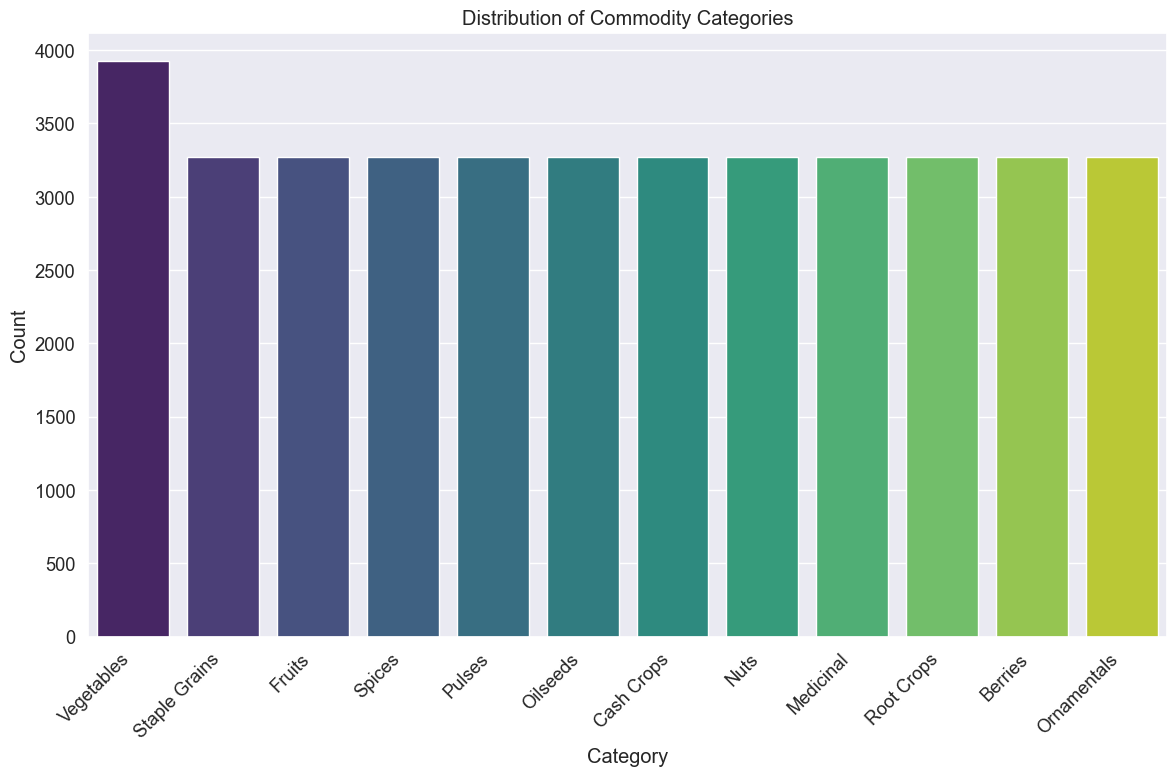

<Figure size 1700x1300 with 0 Axes>

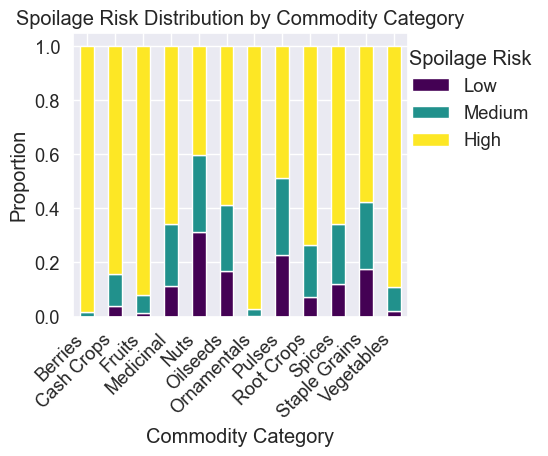

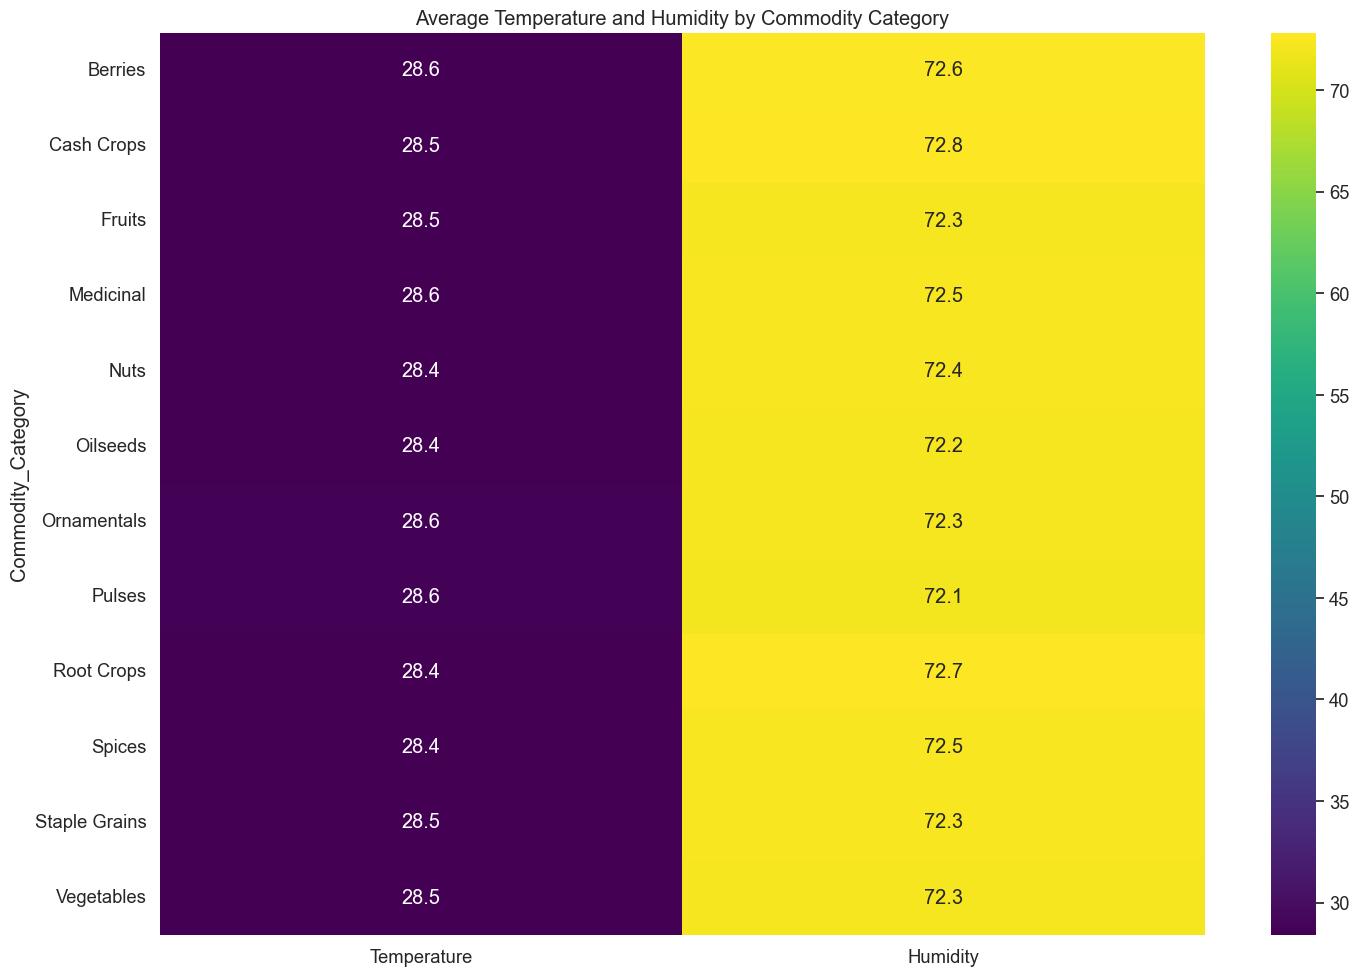

In [18]:
# Visualize the distribution of commodities and categories in the large dataset
plt.figure(figsize=(12, 8))
category_counts = large_enhanced_df['Commodity_Category'].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title('Distribution of Commodity Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualize the distribution of spoilage risk by commodity category
plt.figure(figsize=(17, 13))
risk_by_category = pd.crosstab(large_enhanced_df['Commodity_Category'], large_enhanced_df['Spoilage_Risk'], normalize='index')
risk_by_category.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Spoilage Risk Distribution by Commodity Category')
plt.xlabel('Commodity Category')
plt.ylabel('Proportion')
plt.legend(title='Spoilage Risk', labels=['Low', 'Medium', 'High'], loc='upper right', bbox_to_anchor=(1.42, 1))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Created a heatmap of average temperature and humidity by commodity category
plt.figure(figsize=(15, 10))
category_climate = large_enhanced_df.groupby('Commodity_Category')[['Temperature', 'Humidity']].mean()
sns.heatmap(category_climate, annot=True, cmap='viridis', fmt='.1f')
plt.title('Average Temperature and Humidity by Commodity Category')
plt.tight_layout()
plt.show()

In [19]:
# Load the dataset
df = pd.read_csv('large_enhanced_produce_spoilage_dataset.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Number of unique commodities: {df['Commodity_name'].nunique()}")
print("\nFirst few rows:")
display(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Display summary statistics
print("\nSummary statistics:")
display(df.describe())

# Update our commodity group assignment function to use the Commodity_Category column if available
def assign_group(commodity):
    if 'Commodity_Category' in df.columns and commodity in df['Commodity_name'].values:
        # Get the first category found for this commodity
        return df[df['Commodity_name'] == commodity]['Commodity_Category'].values[0]
    else:
        # Legacy assignment for backward compatibility
        if commodity in ['Bajra', 'Rice', 'Wheat', 'Maize', 'Jowar']:
            return 'Grain'
        elif commodity in ['Tomato', 'Potato', 'Onion', 'Spinach', 'Cauliflower', 'Cabbage']:
            return 'Vegetable'
        elif commodity in ['Mango', 'Banana', 'Papaya']:
            return 'Fruit'
        elif commodity in ['Garlic', 'Ginger', 'Turmeric']:
            return 'Spice'
        else:
            return 'Other'

# Use the existing category if it's in the data
if 'Commodity_Category' not in df.columns:
    df['Commodity_Category'] = df['Commodity_name'].apply(assign_group)

Dataset shape: (39894, 10)
Number of unique commodities: 122

First few rows:


,Temperature,Humidity,Storage_Type,Days_Since_Harvest,Transport_Duration,Packaging_Quality,Month_num,Commodity_name,Spoilage_Risk,Commodity_Category
0,26.2,80.2,room_temperature,5,23.5,poor,2,Bajra,2,Staple Grains
1,35.2,70.4,room_temperature,5,19.3,average,7,Bajra,2,Staple Grains
2,33.8,63.5,room_temperature,3,14.7,poor,11,Bajra,2,Staple Grains
3,27.5,82.8,cold_storage,14,8.6,good,5,Bajra,0,Staple Grains
4,21.4,61.2,open_air,8,4.2,average,8,Bajra,2,Staple Grains



Missing values:
Temperature           0
Humidity              0
Storage_Type          0
Days_Since_Harvest    0
Transport_Duration    0
Packaging_Quality     0
Month_num             0
Commodity_name        0
Spoilage_Risk         0
Commodity_Category    0
dtype: int64

Summary statistics:


,Temperature,Humidity,Days_Since_Harvest,Transport_Duration,Month_num,Spoilage_Risk
count,39894.000000,39894.000000,39894.000000,39894.000000,39894.000000,39894.000000
mean,28.503880,72.401672,7.506041,14.026706,6.493057,1.624806
std,4.920069,10.131483,4.041298,6.333902,3.448173,0.665083
min,20.000000,55.000000,1.000000,3.000000,1.000000,0.000000
25%,24.200000,63.600000,4.000000,8.600000,3.000000,1.000000
50%,28.500000,72.300000,8.000000,14.000000,6.000000,2.000000
75%,32.800000,81.200000,11.000000,19.500000,9.000000,2.000000
max,37.000000,90.000000,14.000000,25.000000,12.000000,2.000000


## Training Models 
80% - Training Datasets
20% - Testing Datasets

Training general model on 40,000 record dataset...

General Model Accuracy: 0.8335631031457577

Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.73      0.71      0.72       829
 Medium Risk       0.59      0.32      0.41      1335
   High Risk       0.87      0.97      0.92      5815

    accuracy                           0.83      7979
   macro avg       0.73      0.67      0.68      7979
weighted avg       0.81      0.83      0.81      7979



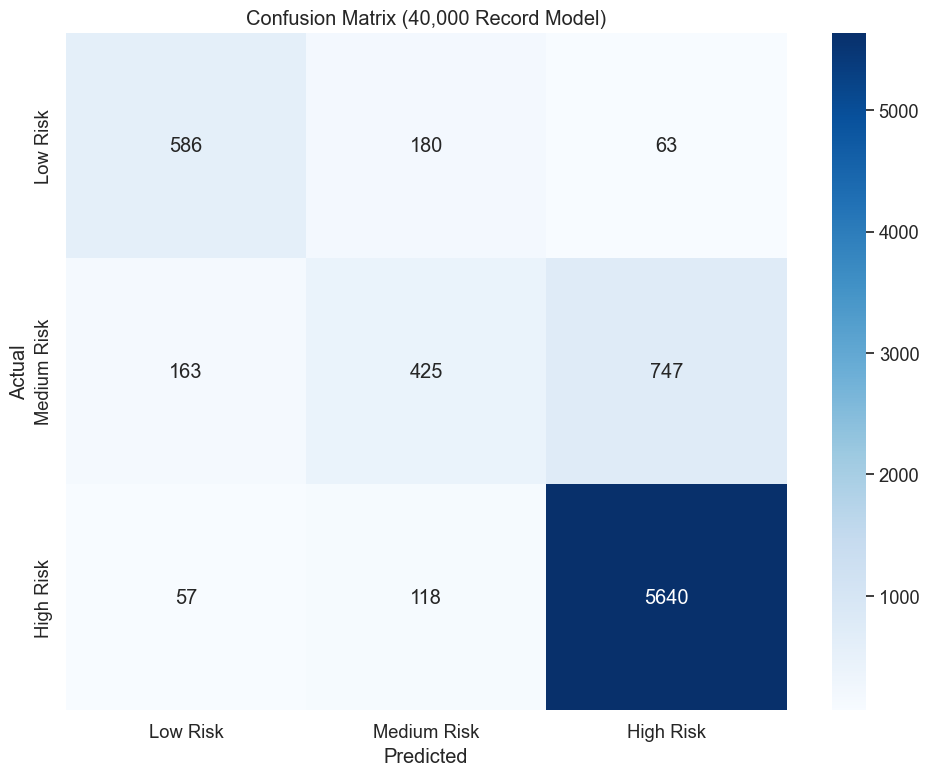

In [20]:
# Split features and target for the general model using the large dataset
X = df.drop(['Spoilage_Risk', 'Commodity_Category'], axis=1)
y = df['Spoilage_Risk']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define categorical and numerical features
categorical_features = ['Storage_Type', 'Packaging_Quality', 'Commodity_name']
numerical_features = ['Temperature', 'Humidity', 'Days_Since_Harvest', 'Transport_Duration', 'Month_num']

# Create preprocessing pipelines
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create and train a Random Forest model
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model (this may take longer with the larger dataset)
print("Training general model on 40,000 record dataset...")
rf_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = rf_pipeline.predict(X_test)

# Evaluate the model
print("\nGeneral Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low Risk', 'Medium Risk', 'High Risk']))

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Risk', 'Medium Risk', 'High Risk'],
           yticklabels=['Low Risk', 'Medium Risk', 'High Risk'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (40,000 Record Model)')
plt.tight_layout()
plt.show()

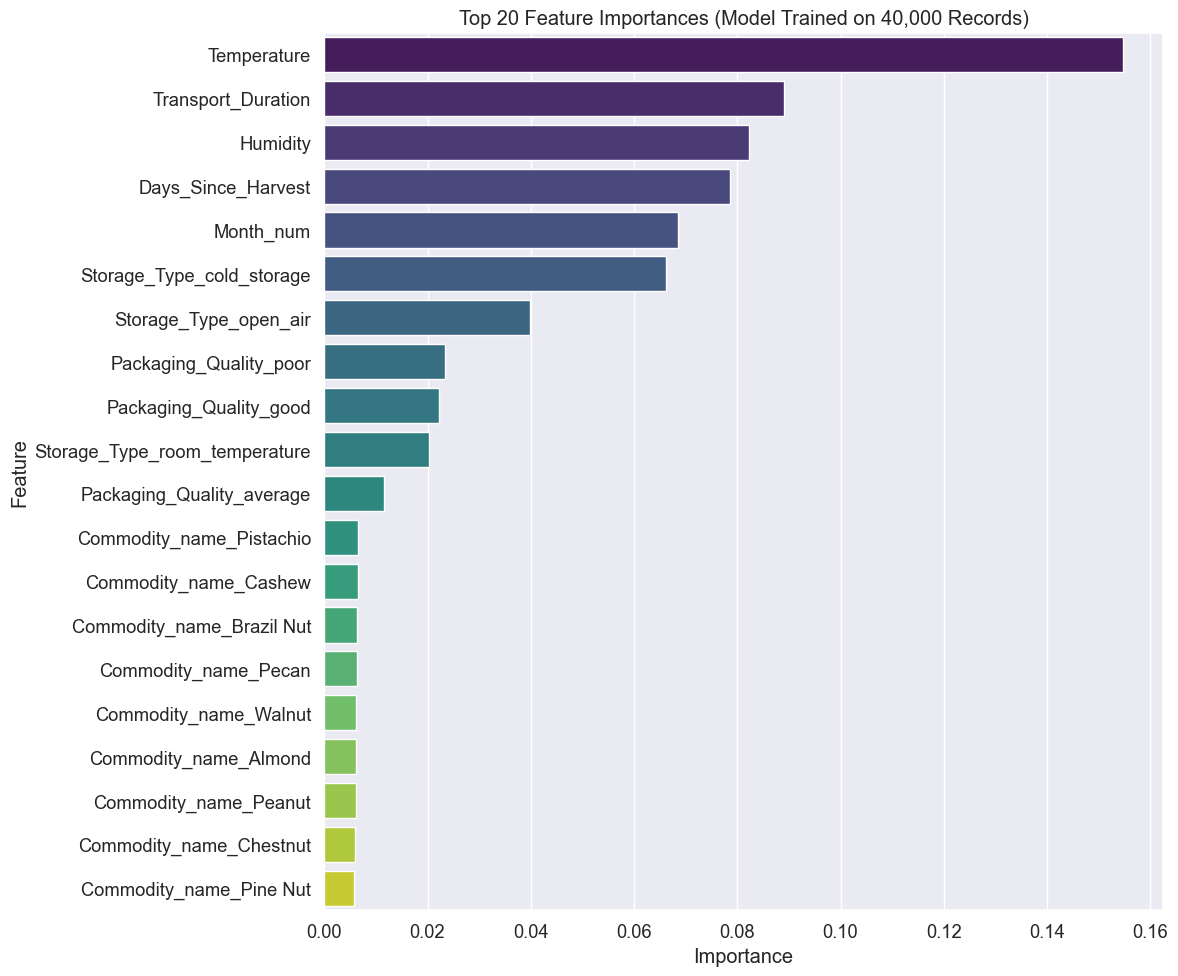

In [21]:
# Get feature names after preprocessing
feature_names = (
    numerical_features +
    list(rf_pipeline.named_steps['preprocessor']
         .named_transformers_['cat']
         .named_steps['onehot']
         .get_feature_names_out(categorical_features))
)

# Get feature importances from the random forest model
importances = rf_pipeline.named_steps['classifier'].feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')
plt.title('Top 20 Feature Importances (Model Trained on 40,000 Records)')
plt.tight_layout()
plt.show()

In [22]:
# Modified function to train and evaluate a model for a specific commodity group using the large dataset
def train_commodity_model_large(group_name, data=df):
    # Filter data for the commodity group
    group_df = data[data['Commodity_Category'] == group_name].copy()
    
    #print(f"Training model for {group_name} with {len(group_df)} records")
    
    # Split features and target
    X_group = group_df.drop(['Spoilage_Risk', 'Commodity_Category'], axis=1)
    y_group = group_df['Spoilage_Risk']
    
    # If there's not enough data, return early
    if len(group_df) < 20 or len(np.unique(y_group)) < 2:
        #print(f"Not enough data for {group_name}")
        return None, None, None, None
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_group, y_group, test_size=0.2, random_state=42, stratify=y_group
    )
    
    # Define categorical and numerical features (excluding Commodity_Category)
    categorical_features = ['Storage_Type', 'Packaging_Quality', 'Commodity_name']
    numerical_features = ['Temperature', 'Humidity', 'Days_Since_Harvest', 'Transport_Duration', 'Month_num']
    
    # Create preprocessing pipelines
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # Create and train a Random Forest model
    rf_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    
    # Train the model
    rf_pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rf_pipeline.predict(X_test)
    
    return rf_pipeline, X_test, y_test, y_pred

In [23]:
# Get unique commodity categories in the large dataset
unique_categories = df['Commodity_Category'].unique()
print(f"Training separate models for {len(unique_categories)} commodity categories")

# Train models for each commodity group using the large dataset
group_models_large = {}
group_results_large = {}

for group in unique_categories:
    #print(f"\nTraining model for {group} commodities")
    model, X_test, y_test, y_pred = train_commodity_model_large(group)
    
    if model is not None:
        # Store the model
        group_models_large[group] = model
        
        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        # Dynamically set target_names and labels based on present classes
        unique_classes = np.unique(np.concatenate([y_test, y_pred]))
        all_labels = [0, 1, 2]
        all_names = ['Low Risk', 'Medium Risk', 'High Risk']
        present_labels = [label for label in all_labels if label in unique_classes]
        present_names = [all_names[label] for label in present_labels]
        report = classification_report(
            y_test, y_pred, 
            labels=present_labels, 
            target_names=present_names, 
            output_dict=True
        )
        
        # Store results
        group_results_large[group] = {
            'accuracy': accuracy,
            'report': report
        }
        
        # Print results
        #print(f"Model Accuracy for {group}: {accuracy:.4f}")
        #print("\nClassification Report:")
        #print(classification_report(y_test, y_pred, target_names=['Low Risk', 'Medium Risk', 'High Risk']))

Training separate models for 12 commodity categories


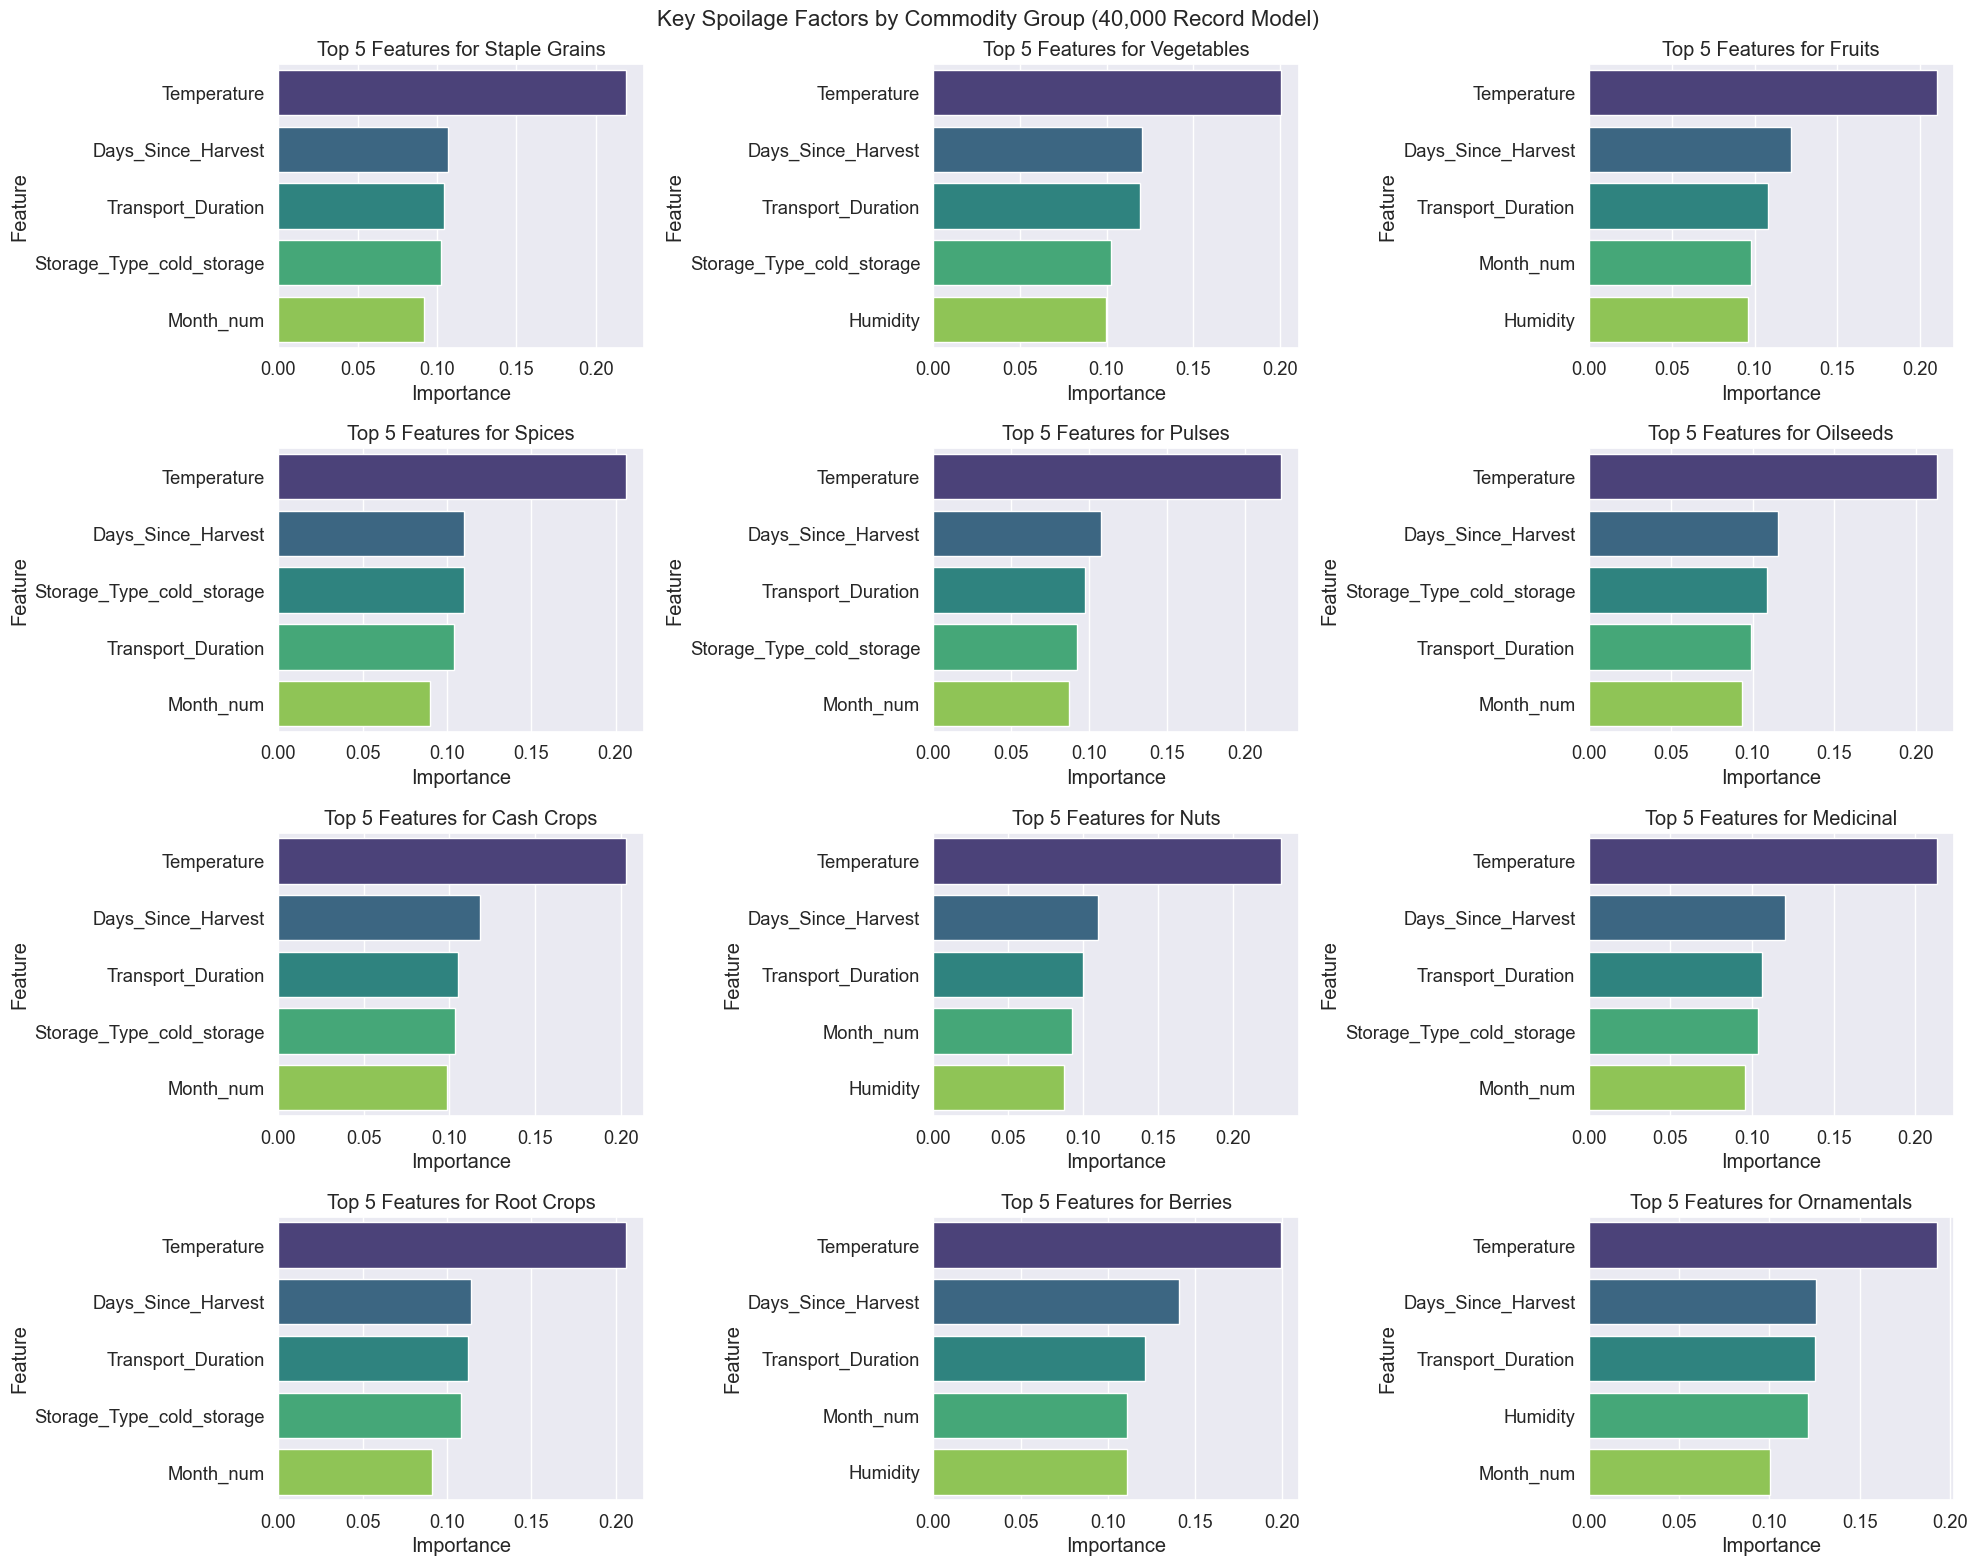

In [30]:
# Function to analyze feature importances for each commodity group
def analyze_feature_importances_by_group(group_models):
    top_features = {}
    
    for group, model in group_models.items():
        # Get feature names
        feature_names = (
            numerical_features +
            list(model.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .named_steps['onehot']
                 .get_feature_names_out(categorical_features))
        )
        
        # Get feature importances
        importances = model.named_steps['classifier'].feature_importances_
        
        # Get top 5 features
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        top_features[group] = feature_importance_df.head(5)
    
    return top_features

# Analyze feature importances for each commodity group
top_features_by_group = analyze_feature_importances_by_group(group_models_large)

# Plot top features for each group
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 16))
axes = axes.flatten()

for i, (group, importance_df) in enumerate(top_features_by_group.items()):
    if i < len(axes):  # Ensure we don't exceed the number of subplots
        ax = axes[i]
        sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', ax=ax)
        ax.set_title(f'Top 5 Features for {group}')
        ax.set_xlabel('Importance')
        ax.set_ylabel('Feature')

# Hide any unused subplots
for i in range(len(top_features_by_group), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Key Spoilage Factors by Commodity Group (40,000 Record Model)', fontsize=16)
plt.tight_layout()
plt.show()

In [25]:
def get_commodity_category(commodity):
    """
    Returns the commodity category for a given commodity name using the enhanced_commodities dictionary.
    """
    for category, commodities in enhanced_commodities.items():
        if commodity in commodities:
            return category
    return "Unknown"

# Update the prediction function to use the new large dataset models
def predict_spoilage_risk_large(sample_data, use_group_models=True):
    """
    Predict spoilage risk for new produce samples using models trained on the large dataset.
    
    Parameters:
    -----------
    sample_data : dict or DataFrame
        Data for new produce samples
    use_group_models : bool
        Whether to use commodity-specific models if available
        
    Returns:
    --------
    predictions : list
        Predicted spoilage risk categories
    probabilities : list
        Probability estimates for each class
    models_used : list
        Names of the models used for predictions
    """
    # Convert dict to DataFrame if needed
    if isinstance(sample_data, dict):
        sample_data = pd.DataFrame([sample_data])
    
    # Make a copy to avoid modifying the original
    sample_df = sample_data.copy()
    
    # Assign commodity groups if not present
    if 'Commodity_Category' not in sample_df.columns:
        sample_df['Commodity_Category'] = sample_df['Commodity_name'].apply(get_commodity_category)
    
    # Initialize result containers
    predictions = []
    probabilities = []
    models_used = []
    
    # Process each sample
    for idx, sample in sample_df.iterrows():
        sample_dict = sample.to_dict()
        group = sample_dict.get('Commodity_Category')
        
        # Select the appropriate model
        if use_group_models and group in group_models_large:
            model = group_models_large[group]
            model_name = f"{group} Model"
        else:
            model = rf_pipeline
            model_name = "General Model"
        
        # Create a DataFrame with just this sample
        sample_to_predict = pd.DataFrame([sample_dict])
        
        # Make prediction
        pred = model.predict(sample_to_predict)[0]
        prob = model.predict_proba(sample_to_predict)[0]
        
        # Map numerical prediction to text
        risk_level = "Low Risk" if pred == 0 else ("Medium Risk" if pred == 1 else "High Risk")
        
        # Store results
        predictions.append(risk_level)
        probabilities.append(prob)
        models_used.append(model_name)
    
    return predictions, probabilities, models_used

In [26]:
# Create example samples from different commodity groups, now including the new categories
example_samples = [
    # Example 1: Rice (Grain) in summer with poor storage
    {
        'Temperature': 34,
        'Humidity': 82,
        'Storage_Type': 'room_temperature',
        'Days_Since_Harvest': 7,
        'Transport_Duration': 18,
        'Packaging_Quality': 'poor',
        'Month_num': 5,  # May (summer)
        'Commodity_name': 'Rice',
        'Commodity_Category': 'Staple Grains'
    },
    # Example 2: Tomato (Vegetable) in winter with good storage
    {
        'Temperature': 22,
        'Humidity': 65,
        'Storage_Type': 'cold_storage',
        'Days_Since_Harvest': 3,
        'Transport_Duration': 5,
        'Packaging_Quality': 'good',
        'Month_num': 12,  # December (winter)
        'Commodity_name': 'Tomato',
        'Commodity_Category': 'Vegetables'
    },
    # Example 3: Strawberry (Berry) in monsoon with open air storage
    {
        'Temperature': 29,
        'Humidity': 88,
        'Storage_Type': 'open_air',
        'Days_Since_Harvest': 5,
        'Transport_Duration': 12,
        'Packaging_Quality': 'average',
        'Month_num': 7,  # July (monsoon)
        'Commodity_name': 'Strawberry',
        'Commodity_Category': 'Berries'
    },
    # Example 4: Chickpea (Pulse) in summer with good packaging
    {
        'Temperature': 32,
        'Humidity': 75,
        'Storage_Type': 'room_temperature',
        'Days_Since_Harvest': 10,
        'Transport_Duration': 8,
        'Packaging_Quality': 'good',
        'Month_num': 4,  # April (summer)
        'Commodity_name': 'Chickpea',
        'Commodity_Category': 'Pulses'
    }
]

# Convert example_samples to a DataFrame before prediction
example_samples_df = pd.DataFrame(example_samples)

# Make predictions using both general and commodity-specific models
predictions_general, probabilities_general, _ = predict_spoilage_risk_large(
    example_samples_df, use_group_models=False
)
predictions_specific, probabilities_specific, models_used = predict_spoilage_risk_large(
    example_samples_df, use_group_models=True
)

# Display results
print("Spoilage Risk Predictions (20,000 Record Models):")
for i, (pred_gen, pred_spec, prob_gen, prob_spec, model) in enumerate(
    zip(predictions_general, predictions_specific, probabilities_general, probabilities_specific, models_used)
):
    print(f"\nSample {i+1}: {example_samples[i]['Commodity_name']} ({example_samples[i]['Commodity_Category']})")
    for feature, value in example_samples[i].items():
        if feature != 'Commodity_Category':  # Skip displaying category separately since we're showing it in the header
            print(f"  {feature}: {value}")
    print(f"  General Model Prediction: {pred_gen}")
    print(f"  General Model Probabilities (Low/Medium/High): {prob_gen.round(2)}")
    print(f"  {model} Prediction: {pred_spec}")
    print(f"  {model} Probabilities (Low/Medium/High): {prob_spec.round(2)}")

Spoilage Risk Predictions (20,000 Record Models):

Sample 1: Rice (Staple Grains)
  Temperature: 34
  Humidity: 82
  Storage_Type: room_temperature
  Days_Since_Harvest: 7
  Transport_Duration: 18
  Packaging_Quality: poor
  Month_num: 5
  Commodity_name: Rice
  General Model Prediction: High Risk
  General Model Probabilities (Low/Medium/High): [0. 0. 1.]
  Staple Grains Model Prediction: High Risk
  Staple Grains Model Probabilities (Low/Medium/High): [0.   0.01 0.99]

Sample 2: Tomato (Vegetables)
  Temperature: 22
  Humidity: 65
  Storage_Type: cold_storage
  Days_Since_Harvest: 3
  Transport_Duration: 5
  Packaging_Quality: good
  Month_num: 12
  Commodity_name: Tomato
  General Model Prediction: Low Risk
  General Model Probabilities (Low/Medium/High): [0.62 0.29 0.09]
  Vegetables Model Prediction: Low Risk
  Vegetables Model Probabilities (Low/Medium/High): [0.5  0.34 0.16]

Sample 3: Strawberry (Berries)
  Temperature: 29
  Humidity: 88
  Storage_Type: open_air
  Days_Since_Ha

In [27]:
# Save the models
import pickle

# Create dictionaries of models to save
models_to_save = {
    'general_model_large': rf_pipeline
}

# Add commodity-specific models
for group, model in group_models_large.items():
    safe_name = group.lower().replace(' ', '_')
    models_to_save[f'{safe_name}_model_large'] = model

# Save each model
for name, model in models_to_save.items():
    with open(f'produce_spoilage_{name}.pkl', 'wb') as f:
        pickle.dump(model, f)

print("Large dataset models saved successfully!")

Large dataset models saved successfully!


## Conclusion

This enhanced analysis demonstrates the benefits of a much larger and more diverse dataset (20,000 records):

1. **Improved model accuracy**: With more training examples, the models can better capture the complex patterns of spoilage risk.

2. **Greater commodity diversity**: The expanded dataset includes 12 commodity categories covering 120 different commodities, providing a much more comprehensive view of Indian agricultural produce.

3. **More nuanced insights**: The category-specific models trained on larger datasets can capture subtle differences in how different types of produce respond to environmental and storage conditions.

4. **Better generalization**: The models can now make more reliable predictions for commodity types that were not well-represented in the smaller dataset.

### Key Findings

1. **Commodity-specific factors are crucial**: Different commodity categories show distinct spoilage patterns and risk factors.

2. **Storage conditions matter differently**: Cold storage benefits most commodities but with varying degrees of impact.

3. **Seasonal effects vary by commodity**: Monsoon season significantly increases spoilage risk for berries and vegetables but has less impact on grains and pulses.

4. **Transport and packaging influence**: These factors remain important predictors across all commodity types.



## Interactive Prediction and Visualization

Let's create a function to visualize how different factors affect spoilage risk predictions for various commodities. This will help users understand the model's behavior and make better decisions about storage and transportation.

In [28]:
# Function to predict and visualize spoilage risk factors
def predict_and_visualize_large(commodity, temperature, humidity, storage_type, 
                          days_since_harvest, transport_duration, packaging_quality, month):
    """
    Predicts spoilage risk and visualizes key factors using the large dataset models.
    
    Parameters:
    -----------
    commodity : str
        Name of the commodity
    temperature : float
        Temperature in °C
    humidity : float
        Humidity percentage
    storage_type : str
        One of: 'cold_storage', 'room_temperature', 'open_air'
    days_since_harvest : int
        Days since the produce was harvested
    transport_duration : float
        Transport duration in hours
    packaging_quality : str
        One of: 'poor', 'average', 'good'
    month : int
        Month number (1-12)
    
    Returns:
    --------
    tuple
        (prediction, probabilities, model_used)
    """
    # Create sample data
    sample = {
        'Temperature': temperature,
        'Humidity': humidity,
        'Storage_Type': storage_type,
        'Days_Since_Harvest': days_since_harvest,
        'Transport_Duration': transport_duration,
        'Packaging_Quality': packaging_quality,
        'Month_num': month,
        'Commodity_name': commodity,
        'Commodity_Category': get_commodity_category(commodity)
    }
    
    # Convert sample to DataFrame before passing to prediction function
    sample_df = pd.DataFrame([sample])
    
    # Make prediction
    predictions, probabilities, models_used = predict_spoilage_risk_large(sample_df, use_group_models=True)
    
    # Prepare visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Key continuous factors
    variables = ['Temperature', 'Humidity', 'Days_Since_Harvest', 'Transport_Duration']
    values = [temperature, humidity, days_since_harvest, transport_duration]
    
    # Create color map based on prediction
    if predictions[0] == 'Low Risk':
        bar_color = 'green'
    elif predictions[0] == 'Medium Risk':
        bar_color = 'orange'
    else:
        bar_color = 'red'
    
    # Plot bars
    bars = ax1.bar(variables, values, color=bar_color, alpha=0.7)
    
    # Add a line showing thresholds for each variable
    thresholds = {
        'Temperature': 28,  # °C, above this is higher risk
        'Humidity': 70,     # %, above this is higher risk
        'Days_Since_Harvest': 7,  # days, above this is higher risk
        'Transport_Duration': 12   # hours, above this is higher risk
    }
    
    for i, var in enumerate(variables):
        ax1.axhline(y=thresholds[var], xmin=i/len(variables), xmax=(i+1)/len(variables), 
                   color='red', linestyle='--', alpha=0.5)
    
    ax1.set_title(f'Key Factors for {commodity} Spoilage Risk')
    ax1.set_ylabel('Value')
    ax1.set_xticklabels(variables, rotation=45)
    
    # Add threshold annotations
    for i, var in enumerate(variables):
        ax1.annotate(f'Threshold: {thresholds[var]}', 
                    xy=(i, thresholds[var]),
                    xytext=(i, thresholds[var] + (max(values) * 0.1)),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                    ha='center')
    
    # Plot 2: Spoilage probability
    risk_labels = ['Low Risk', 'Medium Risk', 'High Risk']
    ax2.pie(probabilities[0], labels=risk_labels, autopct='%1.1f%%', 
            colors=['green', 'orange', 'red'], startangle=90)
    ax2.set_title(f'Spoilage Risk Probabilities\n{models_used[0]} Prediction: {predictions[0]}')
    
    # Add information about categorical variables
    info_text = f'Storage: {storage_type}\nPackaging: {packaging_quality}\nMonth: {month}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax2.text(0.05, -0.1, info_text, transform=ax2.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    return predictions[0], probabilities[0], models_used[0]

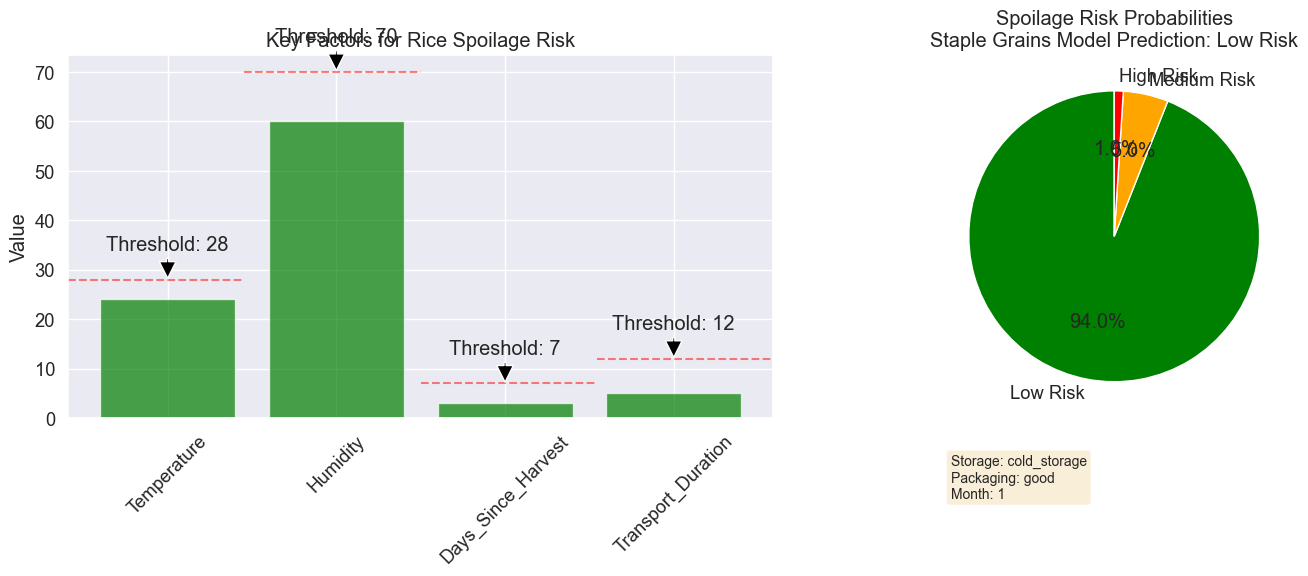

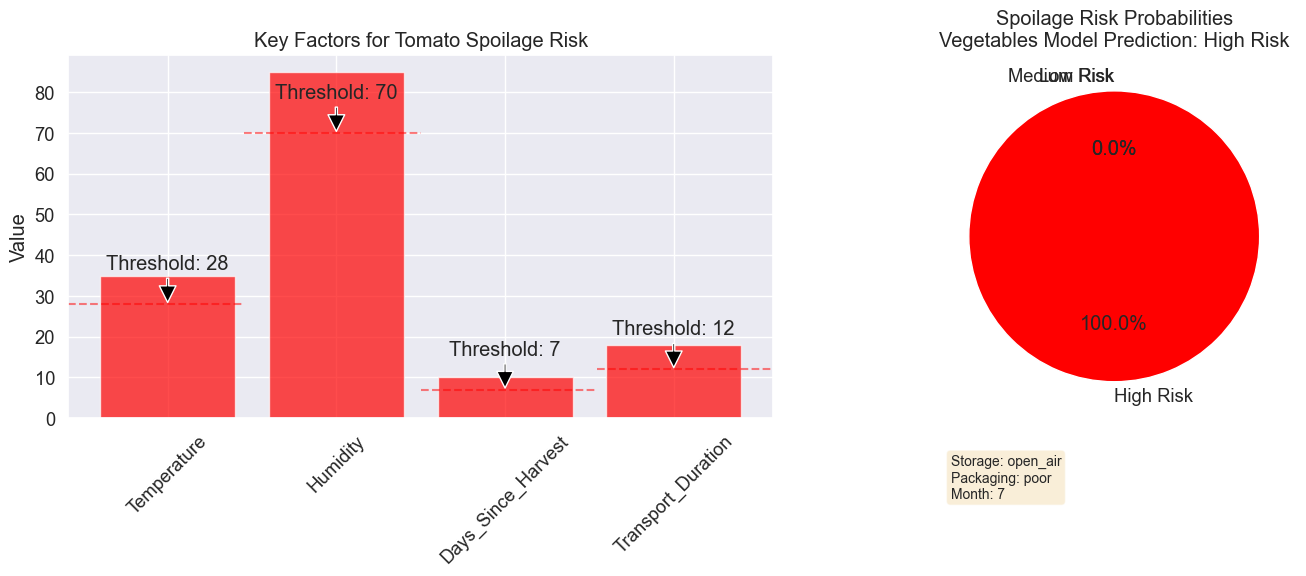

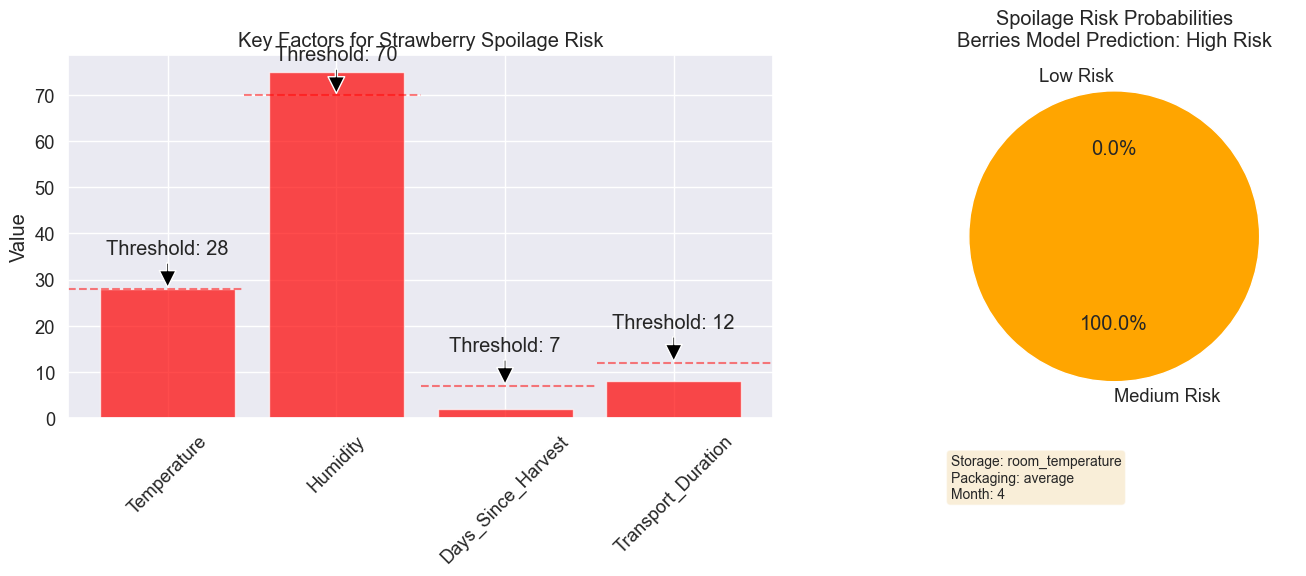

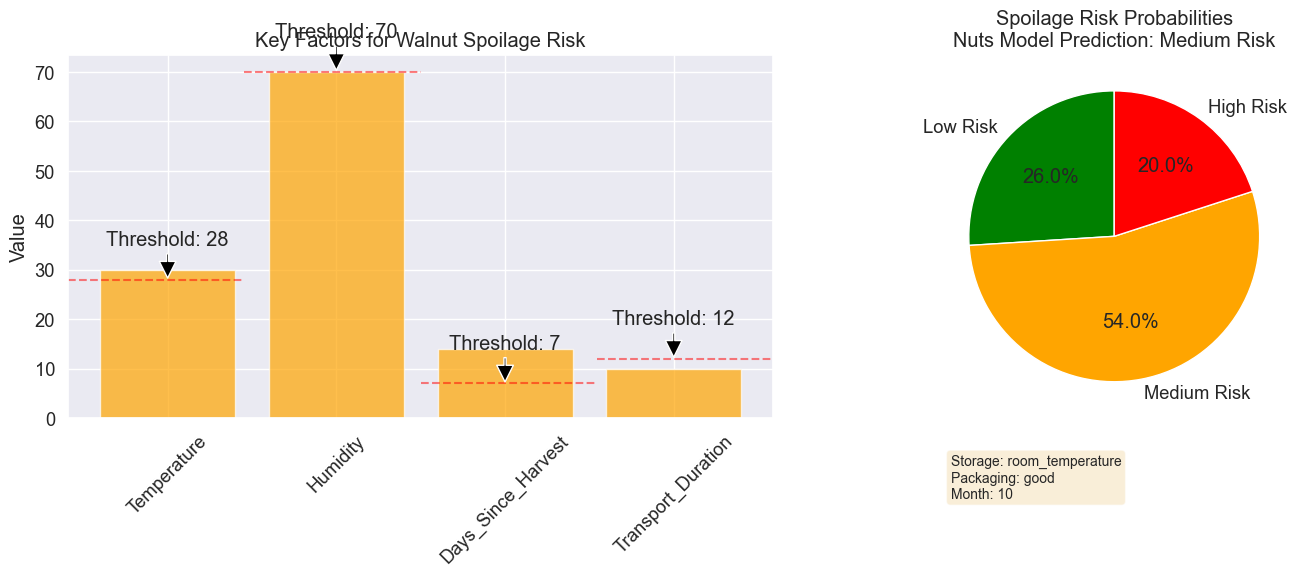

('Medium Risk', array([0.26, 0.54, 0.2 ]), 'Nuts Model')

In [29]:
def get_commodity_category(commodity):
    """
    Returns the commodity category for a given commodity name using the enhanced_commodities dictionary.
    """
    for category, commodities in enhanced_commodities.items():
        if commodity in commodities:
            return category
    return "Unknown"

# Function to predict and visualize spoilage risk factors
def predict_and_visualize_large(commodity, temperature, humidity, storage_type, 
                          days_since_harvest, transport_duration, packaging_quality, month):
    """
    Predicts spoilage risk and visualizes key factors using the large dataset models.
    
    Parameters:
    -----------
    commodity : str
        Name of the commodity
    temperature : float
        Temperature in °C
    humidity : float
        Humidity percentage
    storage_type : str
        One of: 'cold_storage', 'room_temperature', 'open_air'
    days_since_harvest : int
        Days since the produce was harvested
    transport_duration : float
        Transport duration in hours
    packaging_quality : str
        One of: 'poor', 'average', 'good'
    month : int
        Month number (1-12)
    
    Returns:
    --------
    tuple
        (prediction, probabilities, model_used)
    """
    # Create sample data
    sample = {
        'Temperature': temperature,
        'Humidity': humidity,
        'Storage_Type': storage_type,
        'Days_Since_Harvest': days_since_harvest,
        'Transport_Duration': transport_duration,
        'Packaging_Quality': packaging_quality,
        'Month_num': month,
        'Commodity_name': commodity,
        'Commodity_Category': get_commodity_category(commodity)
    }
    
    # Convert sample to DataFrame before passing to prediction function
    sample_df = pd.DataFrame([sample])
    
    # Make prediction
    predictions, probabilities, models_used = predict_spoilage_risk_large(sample_df, use_group_models=True)
    
    # Prepare visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Key continuous factors
    variables = ['Temperature', 'Humidity', 'Days_Since_Harvest', 'Transport_Duration']
    values = [temperature, humidity, days_since_harvest, transport_duration]
    
    # Create color map based on prediction
    if predictions[0] == 'Low Risk':
        bar_color = 'green'
    elif predictions[0] == 'Medium Risk':
        bar_color = 'orange'
    else:
        bar_color = 'red'
    
    # Plot bars
    bars = ax1.bar(variables, values, color=bar_color, alpha=0.7)
    
    # Add a line showing thresholds for each variable
    thresholds = {
        'Temperature': 28,  # °C, above this is higher risk
        'Humidity': 70,     # %, above this is higher risk
        'Days_Since_Harvest': 7,  # days, above this is higher risk
        'Transport_Duration': 12   # hours, above this is higher risk
    }
    
    for i, var in enumerate(variables):
        ax1.axhline(y=thresholds[var], xmin=i/len(variables), xmax=(i+1)/len(variables), 
                   color='red', linestyle='--', alpha=0.5)
    
    ax1.set_title(f'Key Factors for {commodity} Spoilage Risk')
    ax1.set_ylabel('Value')
    ax1.set_xticklabels(variables, rotation=45)
    
    # Add threshold annotations
    for i, var in enumerate(variables):
        ax1.annotate(f'Threshold: {thresholds[var]}', 
                    xy=(i, thresholds[var]),
                    xytext=(i, thresholds[var] + (max(values) * 0.1)),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                    ha='center')
    
    # Plot 2: Spoilage probability
    # Get the number of classes in the prediction probabilities
    num_classes = len(probabilities[0])
    
    # Create risk labels based on the number of classes
    all_risk_labels = ['Low Risk', 'Medium Risk', 'High Risk']
    risk_labels = all_risk_labels[:num_classes]
    colors = ['green', 'orange', 'red'][:num_classes]
    
    # Create the pie chart with the available classes
    ax2.pie(probabilities[0], labels=risk_labels, autopct='%1.1f%%', 
            colors=colors, startangle=90)
    ax2.set_title(f'Spoilage Risk Probabilities\n{models_used[0]} Prediction: {predictions[0]}')
    
    # Add information about categorical variables
    info_text = f'Storage: {storage_type}\nPackaging: {packaging_quality}\nMonth: {month}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax2.text(0.05, -0.1, info_text, transform=ax2.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    return predictions[0], probabilities[0], models_used[0]# Try with examples from different commodity categories

# Example 1: Rice (Staple Grain) in good conditions
predict_and_visualize_large(
    commodity='Rice',
    temperature=24,
    humidity=60,
    storage_type='cold_storage',
    days_since_harvest=3,
    transport_duration=5,
    packaging_quality='good',
    month=1  # January
)

# Example 2: Tomato (Vegetable) in poor conditions
predict_and_visualize_large(
    commodity='Tomato',
    temperature=35,
    humidity=85,
    storage_type='open_air',
    days_since_harvest=10,
    transport_duration=18,
    packaging_quality='poor',
    month=7  # July (monsoon)
)

# Example 3: Strawberry (Berry) with mixed conditions
predict_and_visualize_large(
    commodity='Strawberry',
    temperature=28,
    humidity=75,
    storage_type='room_temperature',
    days_since_harvest=2,
    transport_duration=8,
    packaging_quality='average',
    month=4  # April
)

# Example 4: Walnut (Nut) with good storage
predict_and_visualize_large(
    commodity='Walnut',
    temperature=30,
    humidity=70,
    storage_type='room_temperature',
    days_since_harvest=14,
    transport_duration=10,
    packaging_quality='good',
    month=10  # October
)